In [1]:
import pandas as pd

df = pd.read_csv("concat_data2.csv", na_values=['-'])

df

,Unnamed: 0,2019-12-01 00:00,2019-12-01 00:30,2019-12-01 01:00,2019-12-01 01:30,2019-12-01 02:00,2019-12-01 02:30,2019-12-01 03:00,2019-12-01 03:30,2019-12-01 04:00,...,2021-02-01 19:00,2021-02-01 19:30,2021-02-01 20:00,2021-02-01 20:30,2021-02-01 21:00,2021-02-01 21:30,2021-02-01 22:00,2021-02-01 22:30,2021-02-01 23:00,2021-02-01 23:30
0,0,0.000,0.010,0.000,0.000,0.000,0.000,0.010,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,7.249,7.283,7.299,7.271,7.315,7.438,7.458,7.414,7.409,...,3.847,3.277,4.074,3.591,3.846,3.243,3.585,3.982,3.267,3.145
2,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,3,0.002,0.002,0.002,0.003,0.002,0.002,0.003,0.002,0.003,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.360,1.290,1.310,1.330,1.200,1.290,1.220,1.270,1.180,1.180
105,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.400,0.840,0.920,0.850,0.630,0.660,0.460,0.790,0.840,0.980
106,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.302,0.305,0.308,0.310,0.312,0.316,0.315,0.314,0.317,0.325
107,107,0.028,0.067,0.017,0.025,0.058,0.019,0.019,0.057,0.032,...,0.122,0.117,0.091,0.120,0.100,0.082,0.072,0.075,0.067,0.073


In [2]:
# параметры 
s_day =  1 # период сезонности
s_week = 7
s_month = 31
idx_start = -31*4
d = 31
d_day = 1
idx_start_reg = -31*4
idx_end = -d
idx_end_end = -d

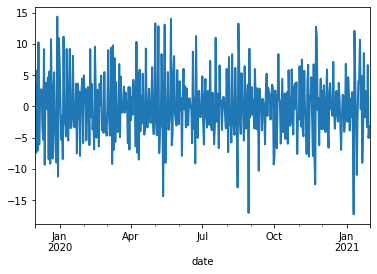

In [50]:
from matplotlib import pyplot as plt
import numpy as np
import random 
import datetime




data = df.iloc[random.choice(range(len(df))), ::]
while data.isnull().values.any():
    data = df.iloc[random.choice(range(len(df))), ::]
        
data = pd.DataFrame(data = {"date":df.columns, "values": data})[1:]
data['date'] = pd.to_datetime(data['date'])


per = data['date'].dt.to_period("d")
data = data.groupby(per)
data_real = data.sum()[:-1]
data = data.mean()[:-1]

data_t_cut =data_real[:-31*3]
data_razn = data_real-data_real.shift(-1).dropna()

ax=data_razn['values'].plot(linewidth = 2)
# print(full_test(np_data, 31*5, d, 50, Composition(comp_models)))

In [51]:
from scipy.optimize import minimize

def MSAE(real, pred):
    return np.power(real-pred, 2).mean()


def MAE(real, pred):
    return abs(real-pred).mean()

def NMAE(real, pred):
    k = 2
    return np.where(real > pred, k*abs(real-pred), abs(real-pred)).mean()


def MRE(predicted, real):
    return abs(real - predicted).sum()/(real.sum())

def error_vec(predicted, real):
    return np.abs(real - predicted)/real

1.7421240342844746
0.6229423047489626


<AxesSubplot:xlabel='date'>

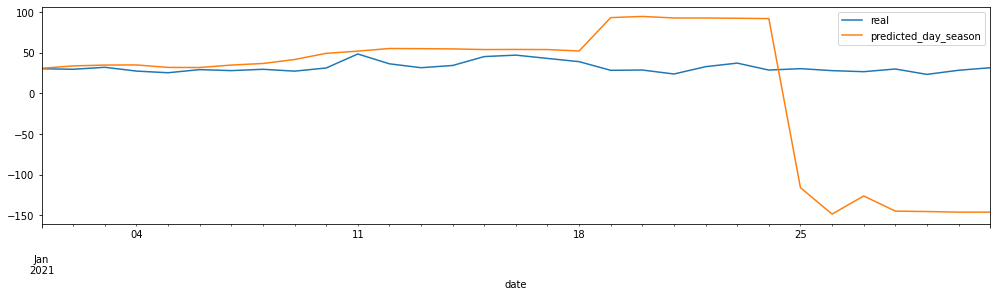

In [62]:
class WintersNoTrend:
    def __init__(self, s):
        self.s = s # период сезонности
        self.a = None
        self.theta = None
        self.n = None
    
    def fit(self, train, alpha):
        self.n = train.shape[0]
    
        self.a = np.zeros(self.n)
        self.theta = np.zeros(self.n)
        m = train.min()
        
        for t in range(self.s):
            self.theta[t] = train[t]
            self.a[t] = train[t]
        
        for t in range(self.s, self.n):
            self.a[t] = alpha[0] * (train[t] / self.theta[t - self.s]) + (1 - alpha[0]) * self.a[t - 1]
            self.theta[t] = alpha[1] * (train[t] / self.a[t]) + (1 - alpha[1]) * self.theta[t - self.s]
    
    def predict(self, d=1):
        y_predicted = np.zeros(d)
        
        for t in range(self.n, self.n + d):
            y_predicted[t - self.n] = self.a[t - d] * self.theta[t - d + (d % self.s) - self.s]
        
        return y_predicted
    
def optimize_alpha(alpha, s, train_data, real_data, d):
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha)
    
    return MAE(real_data, winters_model.predict(d)) + 2.5 * np.power(alpha, 2).sum() # your error function
 
result = minimize(
    lambda x: optimize_alpha(x, s_week, data_razn['values'][idx_start:idx_end-2*d], data_razn['values'][idx_end-2*d:idx_end-d], d),
    x0=np.array([0.5, 0.5]),
    bounds=[(0, 1), (0, 1)]
)
alpha_optimized = result.x
winters_model = WintersNoTrend(s_week)
winters_model.fit(data_razn['values'][idx_start:idx_end], alpha_optimized)

                  
pred = winters_model.predict(d)
data_pred = []
data_pred.append(data_real['values'][idx_end])
for i in range(1, d+1):
    data_pred.append(data_pred[i-1]+pred[i-1])
    
data_pred = np.array(data_pred[1::])
real_next_values = data_real['values'][idx_end:]

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": data_pred

    }
)


print(MRE(data_pred, real_next_values))
print(abs(data_pred.sum() - real_next_values.sum())/(real_next_values.sum()))
results_predict.plot(figsize=(17, 4))

0.1758343458690602
0.14428452930776745


<AxesSubplot:xlabel='date'>

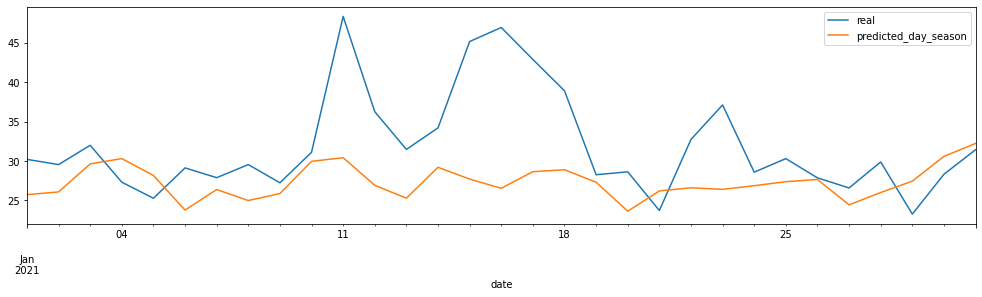

In [54]:
class WintersNoTrend:
    def __init__(self, s):
        self.s = s # период сезонности
        self.a = None
        self.theta = None
        self.n = None
    
    def fit(self, train, alpha):
        self.n = train.shape[0]
    
        self.a = np.zeros(self.n)
        self.theta = np.zeros(self.n)
        m = train.min()
        
        for t in range(self.s):
            self.theta[t] = train[t]
            self.a[t] = train[t]
        
        for t in range(self.s, self.n):
            self.a[t] = alpha[0] * (train[t] / self.theta[t - self.s]) + (1 - alpha[0]) * self.a[t - 1]
            self.theta[t] = alpha[1] * (train[t] / self.a[t]) + (1 - alpha[1]) * self.theta[t - self.s]
    
    def predict(self, d=1):
        y_predicted = np.zeros(d)
        
        for t in range(self.n, self.n + d):
            y_predicted[t - self.n] = self.a[t - d] * self.theta[t - d + (d % self.s) - self.s]
        
        return y_predicted
    
def optimize_alpha(alpha, s, train_data, real_data, d):
    winters_model = WintersNoTrend(s)
    winters_model.fit(train_data, alpha)
    
    return NMAE(real_data, winters_model.predict(d)) # your error function
 
result = minimize(
    lambda x: optimize_alpha(x, s_week, data['values'][idx_start:idx_end-d], data['values'][idx_end-d:idx_end], d),
    x0=np.array([0.5, 0.5]),
    bounds=[(0, 1), (0, 1)]
)
alpha_optimized = result.x
winters_model = WintersNoTrend(s_week)
winters_model.fit(data['values'][idx_start:idx_end], alpha_optimized)

                  
pred = winters_model.predict(d)*48

real_next_values = data_real['values'][idx_end:]

results_predict = pd.DataFrame(
    data={
        "real": real_next_values,
        "predicted_day_season": pred

    }
)


print(MRE(pred, real_next_values))
print(abs(pred.sum() - real_next_values.sum())/(real_next_values.sum()))
results_predict.plot(figsize=(17, 4))